##Feature Analysis

Correlation matrix


+ -1 indicates a perfectly negative linear correlation between two variables
+ 0 indicates no linear correlation between two variables
+ 1 indicates a perfectly positive linear correlation between two variables

###Check requirements

In [ ]:
! python --version

Python 3.7.11


In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [ ]:
pip install contractions

In [ ]:
pip install emojis

In [ ]:
pip install emoji

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [ ]:
!pip3 install -q ktrain 

In [ ]:
pip install -U sklearn

In [ ]:
pip install parse_version

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


###Load data

In [ ]:
# Load train data
train_path = '/content/drive/MyDrive/TeamLab/data/semeval_taskA_corrected.csv'

df_train = pd.read_csv(train_path, header=0, names=['index',
                                                    'irony_label',
                                                    'tweet'])
                                                

In [ ]:
df_train.head()

,index,irony_label,tweet
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


In [ ]:
# Check if dataset is balanced

# Classes are 1 and 0. Tweet can either be ironic or non-ironic -> binary classification
classes = df_train.irony_label.unique()

print((df_train.irony_label == 0).sum())
print((df_train.irony_label == 1).sum())

# => Balanced

1923
1911


In [ ]:
# Load test data
test_path = '/content/drive/MyDrive/TeamLab/data/semeval_taskA_test.csv'

df_test = pd.read_csv(test_path, sep='\t', header=0, names=['index',
                                                            'irony_label',
                                                            'tweet'])

print((df_test.irony_label == 0).sum())
print((df_test.irony_label == 1).sum())

df_test.head()

473
311


,index,irony_label,tweet
0,1,0,@Callisto1947 Can U Help?||More conservatives ...
1,2,1,"Just walked in to #Starbucks and asked for a ""..."
2,3,0,#NOT GONNA WIN http://t.co/Mc9ebqjAqj
3,4,0,@mickymantell He is exactly that sort of perso...
4,5,1,So much #sarcasm at work mate 10/10 #boring 10...


In [ ]:
x_train = df_train['tweet'].to_numpy()
y_train = df_train['irony_label'].to_numpy()

x_test = df_test['tweet'].to_numpy()
y_test = df_test['irony_label'].to_numpy()

In [ ]:
x_train

array(['Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion  http://t.co/fej2v3OUBR',
       "@mrdahl87 We are rumored to have talked to Erv's agent... and the Angels asked about Ed Escobar... that's hardly nothing    ;)",
       'Hey there! Nice to see you Minnesota/ND Winter Weather', ...,
       "well now that i've listened to all of into the woods, i'm going to listen to some FOB #nosurprisethere",
       'Hummingbirds #Are  #Experts #at #Hovering #After #All: #Background #Motion ...: If the hovering ability of the... http://t.co/E189iHBpZr',
       'Only thing missing now is a session at the gym... Want to do every body part though and CV!  #possible'],
      dtype=object)

###Normalisation functions

In [ ]:
import emoji
import contractions
import re

def normalise_for_allcaps(tweet):

    norm_tweet = re.sub("http:.*", "", tweet)
    norm_tweet = re.sub("@[a-zA-Z0-9]+", "", norm_tweet)
    norm_tweet = re.sub(r"[#@!()/_;:{}=~|,\-\.\?\[\]]", "", norm_tweet)
    norm_tweet = re.sub("'s", "", norm_tweet)

    norm_tweet = emoji.demojize(norm_tweet)
    norm_tweet = re.sub(":\s?\w{3,}\s?:", "", norm_tweet)
    norm_tweet = re.sub("\d+", "", norm_tweet)
    norm_tweet = contractions.fix(norm_tweet)
        
    return norm_tweet.strip()


def normalise_for_pol(tweet):

    norm_tweet = re.sub("http:.*", "", tweet) 
    norm_tweet = re.sub("'s", "", norm_tweet)
    norm_tweet = re.sub("@[a-zA-Z0-9]+", "", norm_tweet)

    norm_tweet = emoji.demojize(norm_tweet)
    norm_tweet = re.sub(r"[#@!()/_;:{}=~|,\-\.\?\[\]]", "", norm_tweet)
    norm_tweet = re.sub("\d+", "", norm_tweet)
        
    return norm_tweet.strip()

def normalise_for_pos(tweet):

    norm_tweet = re.sub("http:.*", "", tweet)
    norm_tweet = re.sub("@[a-zA-Z0-9]+", "", norm_tweet)
    norm_tweet = re.sub(r"[#@!()/_;:{}=~|,\-\.\?\[\]]", "", norm_tweet)
    norm_tweet = re.sub("'s", "", norm_tweet)

    norm_tweet = emoji.demojize(norm_tweet)
    norm_tweet = re.sub(":\s?\w{3,}\s?:", "", norm_tweet)
    norm_tweet = re.sub("\d+", "", norm_tweet)
    norm_tweet = contractions.fix(norm_tweet)
    norm_tweet = norm_tweet.lower()

    return norm_tweet.strip()

def normalise_for_punct(tweet):

    norm_tweet = re.sub("http:.*", "", tweet)
    norm_tweet = re.sub("@[a-zA-Z0-9]+", "", norm_tweet)
    norm_tweet = re.sub(r"[#@()/_;:{}=~|,\-\.\[\]]", "", norm_tweet)
    norm_tweet = re.sub("'s", "", norm_tweet)

    norm_tweet = emoji.demojize(norm_tweet)
    norm_tweet = re.sub(":\s?\w{3,}\s?:", "", norm_tweet)
    norm_tweet = re.sub("\d+", "", norm_tweet)
    norm_tweet = contractions.fix(norm_tweet)
    norm_tweet = norm_tweet.lower()

    return norm_tweet.strip()

###All caps

In [ ]:
x_train_mod1 = []
for tweet in x_train:
    x_train_mod1.append(normalise_for_allcaps(tweet))

In [ ]:
def get_all_caps(dataset):
    all_caps = []

    for tweet in dataset:
        upper_w = 0
        n_words = len(tweet.split())
        for word in tweet.split():
            if word == 'I':
                n_words +- 1
            if word != 'I' and word.isupper():
                upper_w += 1

        if upper_w >= round(n_words*80/100):
            all_caps.append(1)
        else:
            all_caps.append(0)
            
    return all_caps

In [ ]:
all_caps = get_all_caps(x_train_mod1)

# Number of tweets with feature all_caps
all_caps.count(1)

53

In [ ]:
df_feat = df_train.copy()

df_feat['all_caps'] = all_caps
df_feat.head()

,index,irony_label,tweet,all_caps
0,1,1,Sweet United Nations video. Just in time for C...,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0
3,4,0,3 episodes left I'm dying over here,0
4,5,1,I can't breathe! was chosen as the most notabl...,0


In [ ]:
len(y_train) == len(all_caps)

True

In [ ]:
df_feat[['irony_label', 'all_caps']].corr()

,irony_label,all_caps
irony_label,1.000000,-0.064412
all_caps,-0.064412,1.000000


In [ ]:
corr_list_allcaps = []
for i in range(len(y_train)):
    if all_caps[i] == 1:
        corr_list_allcaps.append(y_train[i])

print(corr_list_allcaps.count(0))
print(corr_list_allcaps.count(1))

41
12


In [ ]:
p_nonironic = round(corr_list_allcaps.count(0)*100/(corr_list_allcaps.count(0)+corr_list_allcaps.count(1)),2)
p_ironic = round(corr_list_allcaps.count(1)*100/(corr_list_allcaps.count(0)+corr_list_allcaps.count(1)),2)

print("Out of the tweets that contain the feature <all_caps>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <all_caps>, 22.64 % are ironic


###Ellipsis

In [ ]:
def get_ellipsis(dataset):
    ellipsis = []

    for tweet in dataset:
        el = int(bool(re.search("\.\.\.+", tweet)))
        if el == 1:
            ellipsis.append(1)
        else:
            ellipsis.append(0)
            
    return ellipsis

In [ ]:
ellipsis = get_ellipsis(x_train)

# Number of tweets with feature ellipsis
ellipsis.count(1)

484

In [ ]:
df_feat['ellipsis'] = ellipsis
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis
0,1,1,Sweet United Nations video. Just in time for C...,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0
3,4,0,3 episodes left I'm dying over here,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0


In [ ]:
df_feat[['irony_label', 'ellipsis']].corr()

,irony_label,ellipsis
irony_label,1.00000,-0.02237
ellipsis,-0.02237,1.00000


In [ ]:
corr_list_elip = []
for i in range(len(y_train)):
    if ellipsis[i] == 1:
        corr_list_elip.append(y_train[i])

print(corr_list_elip.count(0))
print(corr_list_elip.count(1))

257
227


In [ ]:
p_nonironic = round(corr_list_elip.count(0)*100/(corr_list_elip.count(0)+corr_list_elip.count(1)),2)
p_ironic = round(corr_list_elip.count(1)*100/(corr_list_elip.count(0)+corr_list_elip.count(1)),2)

print("Out of the tweets that contain the feature <ellipsis>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <ellipsis>, 46.9 % are ironic


###Polarity change

In [ ]:
from textblob import TextBlob

In [ ]:
x_train_mod2 = []
for tweet in x_train:
    x_train_mod2.append(normalise_for_pol(tweet))

In [ ]:
def get_pol_change(dataset):
    polarities = []

    for tweet in dataset:
        pol_of_words = []
        for word in tweet.split():
            x = TextBlob(word)
            pol_of_words.append(x.sentiment.polarity)
        if all(p == 0.0 for p in pol_of_words):
            polarities.append([0.0])
        else:
            inner = []
            for p in pol_of_words:
                if p != 0.0:
                    inner.append(p)
            polarities.append(inner)

    pol_change = []
    idx = 0
    for lst in polarities:
        pos = float(sum(pol > 0 for pol in lst))
        neg = float(sum(pol < 0 for pol in lst))
        if pos != 0.0 and neg != 0.0:
            pol_change.append(1)
        else:
            pol_change.append(0)
            
    return pol_change

In [ ]:
pol_change = get_pol_change(x_train_mod2)

In [ ]:
print(pol_change.count(0))
print(pol_change.count(1))

3353
481


In [ ]:
df_feat['pol_change'] = pol_change
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0
3,4,0,3 episodes left I'm dying over here,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0


In [ ]:
df_feat[['irony_label', 'pol_change']].corr()

,irony_label,pol_change
irony_label,1.00000,0.03662
pol_change,0.03662,1.00000


In [ ]:
corr_list_pol = []
for i in range(len(y_train)):
    if pol_change[i] == 1:
        corr_list_pol.append(y_train[i])

print(corr_list_pol.count(0))
print(corr_list_pol.count(1))

218
263


In [ ]:
p_nonironic = round(corr_list_pol.count(0)*100/(corr_list_pol.count(0)+corr_list_pol.count(1)),2)
p_ironic = round(corr_list_pol.count(1)*100/(corr_list_pol.count(0)+corr_list_pol.count(1)),2)

print("Out of the tweets that contain the feature <polarity_change>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <polarity_change>, 54.68 % are ironic


###Number of sentences in tweet

In [ ]:
num_of_sents = []

for tweet in x_train:
    sents = nltk.sent_tokenize(tweet)
    num_of_sents.append(len(sents))

set(num_of_sents)

{1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
df_feat['num_of_sents'] = num_of_sents
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2
3,4,0,3 episodes left I'm dying over here,0,0,0,1
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2


In [ ]:
df_feat[['irony_label', 'num_of_sents']].corr()

,irony_label,num_of_sents
irony_label,1.000000,0.007899
num_of_sents,0.007899,1.000000


In [ ]:
df_feat['num_of_sents'].value_counts()

1    2181
2    1179
3     357
4      91
5      18
8       3
6       3
7       2
Name: num_of_sents, dtype: int64

In [ ]:
for num in set(num_of_sents):
    mask_feat = df_feat['num_of_sents'] == num
    temp_df = df_feat[mask_feat]
    mask_irony = temp_df['irony_label'] == 1
    sliced_df = temp_df[mask_irony]

    irony_count = len(sliced_df)

    percentage = round(irony_count*100/len(temp_df))
    print('Tweets that contain', num, 'sentences are ironic in', percentage, '% of the cases')

Tweets that contain 1 sentences are ironic in 49 % of the cases
Tweets that contain 2 sentences are ironic in 51 % of the cases
Tweets that contain 3 sentences are ironic in 48 % of the cases
Tweets that contain 4 sentences are ironic in 64 % of the cases
Tweets that contain 5 sentences are ironic in 28 % of the cases
Tweets that contain 6 sentences are ironic in 33 % of the cases
Tweets that contain 7 sentences are ironic in 50 % of the cases
Tweets that contain 8 sentences are ironic in 33 % of the cases


In [ ]:
# consider numbers above (the following don't tell us much)
for num in set(num_of_sents):
    mask_irony = df_feat['irony_label'] == 1
    temp_df = df_feat[mask_irony] #contains only (and all) the ironic tweets
    mask_feat = temp_df['num_of_sents'] == num
    sliced_df = temp_df[mask_feat] #only tweets that are both ironic and have num number of sentences

    sents_count = len(sliced_df)

    percentage = sents_count*100/len(temp_df)
    print('Ironic tweets have', num, 'sentences in', percentage, '% of the cases')

Ironic tweets have 1 sentences in 56.25327053898482 % of the cases
Ironic tweets have 2 sentences in 31.39717425431711 % of the cases
Ironic tweets have 3 sentences in 8.895866038723181 % of the cases
Ironic tweets have 4 sentences in 3.035060177917321 % of the cases
Ironic tweets have 5 sentences in 0.2616431187859759 % of the cases
Ironic tweets have 6 sentences in 0.052328623757195186 % of the cases
Ironic tweets have 7 sentences in 0.052328623757195186 % of the cases
Ironic tweets have 8 sentences in 0.052328623757195186 % of the cases


###Lengthening (?)
can't find RE that works

In [ ]:
lengthening = []

for tweet in x_train:
    le = int(bool(re.search("([a-zA-Z])\1{2,}", tweet)))
    if le == 1:
        lengthening.append(1)
    else:
        lengthening.append(0)


# Number of tweets with feature ellipsis
lengthening.count(1)

0

###Laughter

In [ ]:
def get_laugh(dataset):
    laughs = []

    for tweet in dataset:
        laugh = int(bool(re.search(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*)\b", tweet.lower())))
        if laugh == 1:
            laughs.append(1)
        else:
            laughs.append(0)
    return laughs

In [ ]:
laughs = get_laugh(x_train)

In [ ]:
print(laughs.count(0))
print(laughs.count(1))

3700
134


In [ ]:
df_feat['laugh'] = laughs
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0


In [ ]:
df_feat[['irony_label', 'laugh']].corr()

,irony_label,laugh
irony_label,1.000000,0.014798
laugh,0.014798,1.000000


In [ ]:
corr_list_laugh = []
for i in range(len(y_train)):
    if laughs[i] == 1:
        corr_list_laugh.append(y_train[i])

print(corr_list_laugh.count(0))
print(corr_list_laugh.count(1))

62
72


In [ ]:
p_nonironic = round(corr_list_laugh.count(0)*100/(corr_list_laugh.count(0)+corr_list_laugh.count(1)),2)
p_ironic = round(corr_list_laugh.count(1)*100/(corr_list_laugh.count(0)+corr_list_laugh.count(1)),2)

print("Out of the tweets that contain the feature <laugh>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <laugh>, 53.73 % are ironic


###Emojis

In [ ]:
import emojis

In [ ]:
def get_emojis(dataset):
    hasemoji = []

    for tweet in dataset:
        emo = emojis.count(tweet)
        if emo != 0:
            hasemoji.append(1)
        else:
            hasemoji.append(0)
    return hasemoji

In [ ]:
hasemoji = get_emojis(x_train)

print(hasemoji.count(0))
print(hasemoji.count(1))

3433
401


In [ ]:
df_feat['emojis'] = hasemoji
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0


In [ ]:
df_feat[['irony_label', 'emojis']].corr()

,irony_label,emojis
irony_label,1.000000,-0.047511
emojis,-0.047511,1.000000


In [ ]:
corr_list_emojis = []
for i in range(len(y_train)):
    if hasemoji[i] == 1:
        corr_list_emojis.append(y_train[i])

print(corr_list_emojis.count(0))
print(corr_list_emojis.count(1))

229
172


In [ ]:
p_nonironic = round(corr_list_emojis.count(0)*100/(corr_list_emojis.count(0)+corr_list_emojis.count(1)),2)
p_ironic = round(corr_list_emojis.count(1)*100/(corr_list_emojis.count(0)+corr_list_emojis.count(1)),2)

print("Out of the tweets that contain the feature <emojis>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <emojis>, 42.89 % are ironic


###Interjections

In [ ]:
x_train_mod3 = []

for tweet in x_train:
    x_train_mod3.append(normalise_for_pos(tweet))

In [ ]:
def convert_to_pos(dataset):
    # A list of lists, where each inner list represents a sentece.
    # Instead of words, it contains the POS tags of the words present in the original tweet
    x_pos = []

    for tweet in dataset:
        words = nltk.word_tokenize(tweet)
        words_pos = nltk.pos_tag(words)
        pos_tweet = []
        for i in range(len(words_pos)):
            tag = words_pos[i][1]
            pos_tweet.append(tag)
        x_pos.append(pos_tweet)

    return x_pos

In [ ]:
x_train_pos = convert_to_pos(x_train_mod3)

In [ ]:
x_train_pos[2]

['NN', 'EX', 'JJ', 'TO', 'VB', 'PRP', 'VBP', 'JJR', 'NN']

In [ ]:
x_train_mod3[2]

'hey there nice to see you minnesotand winter weather'

In [ ]:
def get_interjection(pos_data):
    interj = []

    for tweet in pos_data:
        if 'UH' in tweet:
            interj.append(1)
        else:
            interj.append(0)
            
    return interj

In [ ]:
interj = get_interjection(x_train_pos)

In [ ]:
print(interj.count(0))
print(interj.count(1))

3801
33


In [ ]:
df_feat['interjection'] = interj
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis,interjection
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0,0


In [ ]:
df_feat[['irony_label', 'interjection']].corr()

,irony_label,interjection
irony_label,1.000000,0.025704
interjection,0.025704,1.000000


In [ ]:
corr_list_interj = []
for i in range(len(y_train)):
    if interj[i] == 1:
        corr_list_interj.append(y_train[i])

print(corr_list_interj.count(0))
print(corr_list_interj.count(1))

12
21


In [ ]:
p_nonironic = round(corr_list_interj.count(0)*100/(corr_list_interj.count(0)+corr_list_interj.count(1)),2)
p_ironic = round(corr_list_interj.count(1)*100/(corr_list_interj.count(0)+corr_list_interj.count(1)),2)

print("Out of the tweets that contain the feature <interjection>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <interjection>, 63.64 % are ironic


###Exclamation

In [ ]:
x_train_mod4 = []

for tweet in x_train:
    x_train_mod4.append(normalise_for_punct(tweet))

In [ ]:
def get_exclamation(dataset):
    exclamation = []

    for tweet in dataset:
        ex = int(bool(re.search("!+", tweet)))
        if ex == 1:
            exclamation.append(1)
        else:
            exclamation.append(0)
    
    return exclamation

In [ ]:
exclamation = get_exclamation(x_train_mod4)

In [ ]:
# Number of tweets with feature exclamation
print(exclamation.count(0))
print(exclamation.count(1))

3194
640


In [ ]:
df_feat['exclamation'] = exclamation
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis,interjection,exclamation
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0,0,1
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0,0,1


In [ ]:
df_feat[['irony_label', 'exclamation']].corr()

,irony_label,exclamation
irony_label,1.00000,0.01539
exclamation,0.01539,1.00000


In [ ]:
corr_list_excl = []
for i in range(len(y_train)):
    if exclamation[i] == 1:
        corr_list_excl.append(y_train[i])

print(corr_list_excl.count(0))
print(corr_list_excl.count(1))

310
330


In [ ]:
p_nonironic = round(corr_list_excl.count(0)*100/(corr_list_excl.count(0)+corr_list_excl.count(1)),2)
p_ironic = round(corr_list_excl.count(1)*100/(corr_list_excl.count(0)+corr_list_excl.count(1)),2)

print("Out of the tweets that contain the feature <exclamation>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <exclamation>, 51.56 % are ironic


###Hard exclamation

In [ ]:
def get_hard_exclamation(dataset):
    hard_exclamation = []

    for tweet in dataset:
        #match 2 or more exclamation marks --> change to 3?
        hard_ex = int(bool(re.search("!{2,}", tweet)))
        if hard_ex == 1:
            hard_exclamation.append(1)
        else:
            hard_exclamation.append(0)
    
    return hard_exclamation

In [ ]:
hard_exclamation = get_hard_exclamation(x_train_mod4)

In [ ]:
# Number of tweets with feature ellipsis
print(hard_exclamation.count(0))
print(hard_exclamation.count(1))

3683
151


In [ ]:
df_feat['hard_exclamation'] = hard_exclamation
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis,interjection,exclamation,hard_exclamation
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0,0,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0,0,1,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0,0,1,0


In [ ]:
df_feat[['irony_label', 'hard_exclamation']].corr()

,irony_label,hard_exclamation
irony_label,1.000000,0.020748
hard_exclamation,0.020748,1.000000


In [ ]:
corr_list_hard_excl = []
for i in range(len(y_train)):
    if hard_exclamation[i] == 1:
        corr_list_hard_excl.append(y_train[i])

print(corr_list_hard_excl.count(0))
print(corr_list_hard_excl.count(1))

68
83


In [ ]:
p_nonironic = round(corr_list_hard_excl.count(0)*100/(corr_list_hard_excl.count(0)+corr_list_hard_excl.count(1)),2)
p_ironic = round(corr_list_hard_excl.count(1)*100/(corr_list_hard_excl.count(0)+corr_list_hard_excl.count(1)),2)

print("Out of the tweets that contain the feature <hard_exclamation>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <hard_exclamation>, 54.97 % are ironic


###Interrogative

In [ ]:
def get_interrogative(dataset):
    interr = []

    for tweet in dataset:
        q = int(bool(re.search("\?+", tweet)))
        if q == 1:
            interr.append(1)
        else:
            interr.append(0)
    
    return interr

In [ ]:
interr = get_interrogative(x_train_mod4)

In [ ]:
# Number of tweets with feature interr
print(interr.count(0))
print(interr.count(1))

3422
412


In [ ]:
df_feat['interrogative'] = interr
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis,interjection,exclamation,hard_exclamation,interrogative
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0,0,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0,0,0,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0,0,1,0,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0,0,1,0,0


In [ ]:
df_feat[['irony_label', 'interrogative']].corr()

,irony_label,interrogative
irony_label,1.00000,-0.05113
interrogative,-0.05113,1.00000


In [ ]:
corr_list_interr = []
for i in range(len(y_train)):
    if interr[i] == 1:
        corr_list_interr.append(y_train[i])

print(corr_list_interr.count(0))
print(corr_list_interr.count(1))

237
175


In [ ]:
p_nonironic = round(corr_list_interr.count(0)*100/(corr_list_interr.count(0)+corr_list_interr.count(1)),2)
p_ironic = round(corr_list_interr.count(1)*100/(corr_list_interr.count(0)+corr_list_interr.count(1)),2)

print("Out of the tweets that contain the feature <interrogative>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <interrogative>, 42.48 % are ironic


###Hard interrogative

In [ ]:
def get_hard_interrogative(dataset):
    hard_interr = []

    for tweet in dataset:
        #match 2 or more exclamation marks --> change to 3?
        hard_q = int(bool(re.search("\?{3,}", tweet)))
        if hard_q == 1:
            hard_interr.append(1)
        else:
            hard_interr.append(0)

    return hard_interr

In [ ]:
hard_interr = get_hard_interrogative(x_train_mod4)

In [ ]:
# Number of tweets with feature hard_interr
print(hard_interr.count(0))
print(hard_interr.count(1))

3823
11


In [ ]:
df_feat['hard_interr'] = hard_interr
df_feat.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,num_of_sents,laugh,emojis,interjection,exclamation,hard_exclamation,interrogative,hard_interr
0,1,1,Sweet United Nations video. Just in time for C...,0,0,0,3,0,0,0,0,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,1,0,1,0,0,0,0,0,0,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,0,0,2,0,0,0,1,0,0,0
3,4,0,3 episodes left I'm dying over here,0,0,0,1,0,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,0,0,2,0,0,0,1,0,0,0


In [ ]:
df_feat[['irony_label', 'hard_interr']].corr()

,irony_label,hard_interr
irony_label,1.000000,-0.004709
hard_interr,-0.004709,1.000000


In [ ]:
corr_list_hard_interr = []
for i in range(len(y_train)):
    if hard_interr[i] == 1:
        corr_list_hard_interr.append(y_train[i])

print(corr_list_hard_interr.count(0))
print(corr_list_hard_interr.count(1))

6
5


In [ ]:
p_nonironic = round(corr_list_hard_interr.count(0)*100/(corr_list_hard_interr.count(0)+corr_list_hard_interr.count(1)),2)
p_ironic = round(corr_list_hard_interr.count(1)*100/(corr_list_hard_interr.count(0)+corr_list_hard_interr.count(1)),2)

print("Out of the tweets that contain the feature <hard_interr>,", p_ironic, "% are ironic")

Out of the tweets that contain the feature <hard_interr>, 45.45 % are ironic


##Convert word tweets to feature tweets

In [ ]:
#variable names for reference
all_caps
ellipsis
pol_change
laughs
hasemoji
interj
interr
hard_interr
exclamation
hard_exclamation
#num_of_sents??

In [ ]:
len(x_train) == len(df_feat)

True

In [ ]:
new_x_train = []

for tweet in range(len(df_feat)):
    feat_tweet = []
    if df_feat['all_caps'][tweet] == 1:
        feat_tweet.append('<all_caps>')
    if df_feat['ellipsis'][tweet] == 1:
        feat_tweet.append('<ellipsis>')
    if df_feat['pol_change'][tweet] == 1:
        feat_tweet.append('<pol_change>')
    if df_feat['laugh'][tweet] == 1:
        feat_tweet.append('<laugh>')
    if df_feat['interjection'][tweet] == 1:
        feat_tweet.append('<interjection>')
    if df_feat['exclamation'][tweet] == 1:
        feat_tweet.append('<exclamation>')
    if df_feat['hard_exclamation'][tweet] == 1:
        feat_tweet.append('<hard_exclamation>')
    if df_feat['interrogative'][tweet] == 1:
        feat_tweet.append('<interrogative>')
    if df_feat['hard_interr'][tweet] == 1:
        feat_tweet.append('<hard_interr>')
    
    [feat_tweet.append(i) for i in x_train_pos[tweet]] #append every element of the inner list

    feat_tweet_str = ' '.join(feat_tweet)
    new_x_train.append(feat_tweet_str)

#change names <>

In [ ]:
new_x_train[:5]

['NN JJ NNS NN RB IN NN IN JJ NN NN',
 '<ellipsis> PRP VBP VBN TO VB VBN TO VB NN CC DT NNS VBN IN JJ NN WDT RB NN',
 '<exclamation> NN EX JJ TO VB PRP VBP JJR NN',
 'NNS VBD JJ VBP VBG IN RB',
 '<exclamation> NN MD RB VB VBD VBN IN DT RBS JJ NN IN DT NN IN DT JJ NN VBN IN DT NN NN NN']

##Irony detection using features (instead of words)

data: SemEval 2018 tweets

###Convert test data to feature tweets

In [ ]:
x_test_mod1 = []

for tweet in x_test:
    x_test_mod1.append(normalise_for_allcaps(tweet))

In [ ]:
all_caps_test = get_all_caps(x_test_mod1)

In [ ]:
ellipsis_test = get_ellipsis(x_test)

In [ ]:
x_test_mod2 = []

for tweet in x_test:
    x_test_mod2.append(normalise_for_pol(tweet))

In [ ]:
pol_change_test = get_pol_change(x_test_mod2)

In [ ]:
hasemoji_test = get_emojis(x_test)

In [ ]:
laughs_test = get_laugh(x_test)

In [ ]:
x_test_mod3 = []

for tweet in x_test:
    x_test_mod3.append(normalise_for_pos(tweet))

In [ ]:
x_test_pos = convert_to_pos(x_test_mod3)

In [ ]:
interj_test = get_interjection(x_test_pos)

In [ ]:
x_test_mod4 = []

for tweet in x_test:
    x_test_mod4.append(normalise_for_punct(tweet))

In [ ]:
exclamation_test = get_exclamation(x_test_mod4)

In [ ]:
hard_exclamation_test = get_hard_exclamation(x_test_mod4)

In [ ]:
interr_test = get_interrogative(x_test_mod4)

In [ ]:
hard_interr_test = get_hard_interrogative(x_test_mod4)

In [ ]:
list(df_feat.columns)

['index',
 'irony_label',
 'tweet',
 'all_caps',
 'ellipsis',
 'pol_change',
 'num_of_sents',
 'laugh',
 'emojis',
 'interjection',
 'exclamation',
 'hard_exclamation',
 'interrogative',
 'hard_interr']

In [ ]:
df_feat_test = df_test.copy()

df_feat_test['all_caps'] = all_caps_test
df_feat_test['ellipsis'] = ellipsis_test
df_feat_test['pol_change'] = pol_change_test
df_feat_test['laugh'] = laughs_test
df_feat_test['emojis'] = hasemoji_test
df_feat_test['interjection'] = interj_test
df_feat_test['exclamation'] = exclamation_test
df_feat_test['hard_exclamation'] = hard_exclamation_test
df_feat_test['interrogative'] = interr_test
df_feat_test['hard_interr'] = hard_interr_test

df_feat_test.head()

,index,irony_label,tweet,all_caps,ellipsis,pol_change,laugh,emojis,interjection,exclamation,hard_exclamation,interrogative,hard_interr
0,1,0,@Callisto1947 Can U Help?||More conservatives ...,0,0,0,0,0,0,1,0,1,0
1,2,1,"Just walked in to #Starbucks and asked for a ""...",0,0,0,1,0,0,0,0,0,0
2,3,0,#NOT GONNA WIN http://t.co/Mc9ebqjAqj,0,0,0,0,0,0,0,0,0,0
3,4,0,@mickymantell He is exactly that sort of perso...,0,0,0,0,0,0,1,0,0,0
4,5,1,So much #sarcasm at work mate 10/10 #boring 10...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# convert to feature tweets

new_x_test = []

for tweet in range(len(df_feat_test)):
    feat_tweet = []
    if df_feat_test['all_caps'][tweet] == 1:
        feat_tweet.append('<all_caps>')
    if df_feat_test['ellipsis'][tweet] == 1:
        feat_tweet.append('<ellipsis>')
    if df_feat_test['pol_change'][tweet] == 1:
        feat_tweet.append('<pol_change>')
    if df_feat_test['laugh'][tweet] == 1:
        feat_tweet.append('<laugh>')
    if df_feat_test['interjection'][tweet] == 1:
        feat_tweet.append('<interjection>')
    if df_feat_test['exclamation'][tweet] == 1:
        feat_tweet.append('<exclamation>')
    if df_feat_test['hard_exclamation'][tweet] == 1:
        feat_tweet.append('<hard_exclamation>')
    if df_feat_test['interrogative'][tweet] == 1:
        feat_tweet.append('<interrogative>')
    if df_feat_test['hard_interr'][tweet] == 1:
        feat_tweet.append('<hard_interr>')
    
    [feat_tweet.append(i) for i in x_test_pos[tweet]] #append every element of the inner list

    feat_tweet_str = ' '.join(feat_tweet)
    new_x_test.append(feat_tweet_str)

#change names <>

In [ ]:
new_x_test[:5]

['<exclamation> <interrogative> MD PRP VB NNS VBN IN NN NN NN VBN VBG NN IN JJ $ MD VB TO',
 "<laugh> RB VBN IN TO NNS CC VBD IN DT `` JJ NN '' NN NN",
 'RB VBG TO VB',
 '<exclamation> PRP VBZ RB IN NN IN NN NN',
 '<pol_change> RB JJ NN IN NN NN JJ NN JJ NN JJ IN NN RB VBG NN MD RB VB DT NN']

###Model: roberta-base 

In [ ]:
# Check max/mean length of tweets
from statistics import mean

seq_len = []

idx = 0
for tweet in new_x_train:
    if len(tweet.split()) > 35:
        print(idx, tweet)
    seq_len.append(len(tweet.split()))
    idx += 1

print(max(seq_len))
print(mean(seq_len))

35
13.43114241001565


In [ ]:
import ktrain
from ktrain import text


categories = [0, 1]

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
t = text.Transformer(MODEL_NAME, maxlen=100, class_names=categories)

# Using normalised input data
trn = t.preprocess_train(new_x_train, y_train)
val = t.preprocess_test(new_x_test, y_test)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


preprocessing train...
language: de
train sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 28


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 14
	95percentile : 25
	99percentile : 28


###Train

In [ ]:
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs
# LR==(5e-5)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

# if epochs is None, then early_stopping and reduce_on_plateau are atomatically set to 6 and 3, respectively.
# if lr missing, it will be estimated (initial lr)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
240/240 [==============================] - 100s 354ms/step - loss: 0.6955 - accuracy: 0.5076 - val_loss: 0.6932 - val_accuracy: 0.3967
Epoch 2/1024
240/240 [==============================] - 84s 348ms/step - loss: 0.6944 - accuracy: 0.5029 - val_loss: 0.6877 - val_accuracy: 0.6033
Epoch 3/1024
240/240 [==============================] - 84s 347ms/step - loss: 0.6950 - accuracy: 0.5016 - val_loss: 0.6919 - val_accuracy: 0.6033
Epoch 4/1024
240/240 [==============================] - 84s 347ms/step - loss: 0.6941 - accuracy: 0.4932 - val_loss: 0.6917 - val_accuracy: 0.6033

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
240/240 [==============================] - 84s 347ms/step - loss: 0.6944 - accuracy: 0.4943 - val_loss: 0.6956 - val_acc

###Evaluate

In [ ]:
learner.validate(class_names=t.get_classes()) 

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       473
           1       0.00      0.00      0.00       311

    accuracy                           0.60       784
   macro avg       0.30      0.50      0.38       784
weighted avg       0.36      0.60      0.45       784



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[473,   0],
       [311,   0]])

##Emotion classification using features (instead of words)

###Load TweetEval data + fix

In [ ]:
# Load train data
train_path_TE = '/content/drive/MyDrive/TeamLab/data/tweeteval-train_text.txt'

with open(train_path_TE) as f:
    x_train_TE = f.read().splitlines()

In [ ]:
x_train_TE[:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry ",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs ",
 "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu ",
 "Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight ",
 "it's pretty depressing when u hit pan on ur favourite highlighter "]

In [ ]:
with open('/content/drive/MyDrive/TeamLab/data/tweeteval-train_labels.txt') as f:
    y_train_TE = f.read().splitlines()

In [ ]:
y_train_TE[:5]

['2', '0', '1', '0', '3']

In [ ]:
# Convert numbers to emotion labels
y_train_emo = []

for label in y_train:
    if label == '0':
        y_train_emo.append('anger')
    elif label == '1':
        y_train_emo.append('joy')
    elif label == '2':
        y_train_emo.append('optimism')
    elif label == '3':
        y_train_emo.append('sadness')

In [ ]:
y_train_emo[:5]

['optimism', 'anger', 'joy', 'anger', 'sadness']

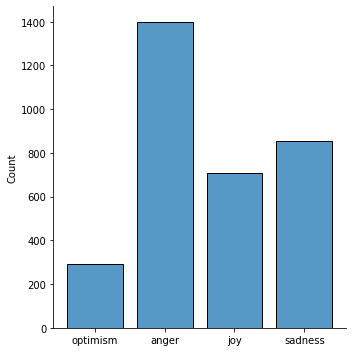

In [ ]:
# Check distribution
import seaborn as sns

sns.displot(y_train_emo, shrink=.8)

In [ ]:
# Create new dataset (balanced)
new_x_train_TE = []
new_y_train_TE = []

idx = 0
for label in y_train_emo:
    if new_y_train_TE.count(label) < 320:
        new_y_train_TE.append(label)
        new_x_train_TE.append(x_train[idx])
    idx += 1
    
new_x_train_TE[:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry ",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs ",
 "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu ",
 "Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight ",
 "it's pretty depressing when u hit pan on ur favourite highlighter "]

In [ ]:
new_y_train_TE[:5]

['optimism', 'anger', 'joy', 'anger', 'sadness']

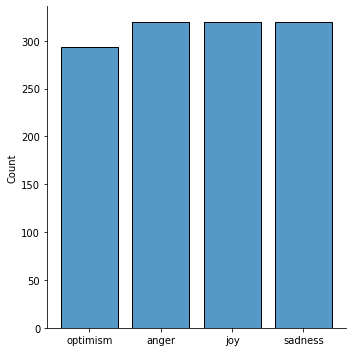

In [ ]:
# Distribution of modified dataset
import seaborn as sns

sns.displot(new_y_train_TE, shrink=.8)

In [ ]:
# Load test data
test_path_TE = '/content/drive/MyDrive/TeamLab/data/tweeteval-test_text.txt'

with open(test_path_TE) as f:
    x_test_TE = f.read().splitlines()

In [ ]:
x_test_TE[:5]

['#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse ',
 '@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still... ',
 'My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression ',
 '@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships ',
 'What makes you feel #joyful? ']

In [ ]:
with open('/content/drive/MyDrive/TeamLab/data/tweeteval-test_labels.txt') as f:
    y_test_TE = f.read().splitlines()

In [ ]:
y_test_TE[:5]

['3', '0', '3', '1', '1']

In [ ]:
# Convert numbers to emotion labels
y_test_emo = []

for label in y_test:
    if label == '0':
        y_test_emo.append('anger')
    elif label == '1':
        y_test_emo.append('joy')
    elif label == '2':
        y_test_emo.append('optimism')
    elif label == '3':
        y_test_emo.append('sadness')

In [ ]:
y_test_emo[:5]

['sadness', 'anger', 'sadness', 'joy', 'joy']

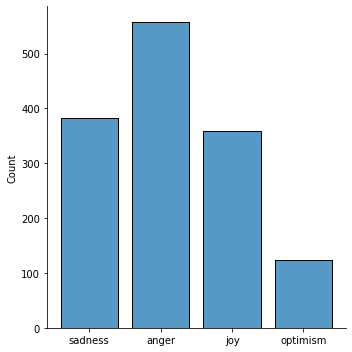

In [ ]:
# Check distribution
import seaborn as sns

sns.displot(y_test_emo, shrink=.8)

In [ ]:
# Create new dataset (balanced)
new_x_test_TE = []
new_y_test_TE = []

idx = 0
for label in y_test_emo:
    if new_y_test_TE.count(label) < 120:
        new_y_test_TE.append(label)
        new_x_test_TE.append(x_test[idx])
    idx += 1
    
new_x_test_TE[:5]

['#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse ',
 '@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still... ',
 'My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression ',
 '@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships ',
 'What makes you feel #joyful? ']

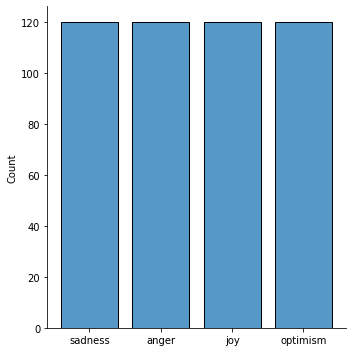

In [ ]:
# Distribution of modified dataset
import seaborn as sns

sns.displot(new_y_test_TE, shrink=.8)

###Convert train data

In [ ]:
x_train_mod1_TE = []

for tweet in new_x_train_TE:
    x_train_mod1_TE.append(normalise_for_allcaps(tweet))

In [ ]:
all_caps_train_TE = get_all_caps(x_train_mod1_TE)

In [ ]:
ellipsis_train_TE = get_ellipsis(new_x_train_TE)

In [ ]:
x_train_mod2_TE = []

for tweet in new_x_train_TE:
    x_train_mod2_TE.append(normalise_for_pol(tweet))

In [ ]:
pol_change_train_TE = get_pol_change(x_train_mod2_TE)

In [ ]:
hasemoji_train_TE = get_emojis(new_x_train_TE)

In [ ]:
laughs_train_TE = get_laugh(new_x_train_TE)

In [ ]:
x_train_mod3_TE = []

for tweet in new_x_train_TE:
    x_train_mod3_TE.append(normalise_for_pos(tweet))

In [ ]:
x_train_pos_TE = convert_to_pos(x_train_mod3_TE)

In [ ]:
interj_train_TE = get_interjection(x_train_pos_TE)

In [ ]:
x_train_mod4_TE = []

for tweet in new_x_train_TE:
    x_train_mod4_TE.append(normalise_for_punct(tweet))

In [ ]:
exclamation_train_TE = get_exclamation(x_train_mod4_TE)

In [ ]:
hard_exclamation_train_TE = get_hard_exclamation(x_train_mod4_TE)

In [ ]:
interr_train_TE = get_interrogative(x_train_mod4_TE)

In [ ]:
hard_interr_train_TE = get_hard_interrogative(x_train_mod4_TE)

In [ ]:
#Check that lengths are consistent
print(len(all_caps_train_TE))
print(len(ellipsis_train_TE))
print(len(pol_change_train_TE))
print(len(hasemoji_train_TE))
print(len(laughs_train_TE))
print(len(interj_train_TE))
print(len(exclamation_train_TE))
print(len(hard_exclamation_train_TE))
print(len(interr_train_TE))
print(len(hard_interr_train_TE))

In [ ]:
df_feat_TE = pd.DataFrame(
    {'emotion': new_y_train_TE,
     'tweet': new_x_train_TE})

df_feat_TE.head()

,emotion,tweet
0,optimism,“Worry is a down payment on a problem you may ...
1,anger,My roommate: it's okay that we can't spell bec...
2,joy,No but that's so cute. Atsu was probably shy a...
3,anger,Rooneys fucking untouchable isn't he? Been fuc...
4,sadness,it's pretty depressing when u hit pan on ur fa...


In [ ]:
df_feat_TE['all_caps'] = all_caps_train_TE
df_feat_TE['ellipsis'] = ellipsis_train_TE
df_feat_TE['pol_change'] = pol_change_train_TE
df_feat_TE['laugh'] = laughs_train_TE
df_feat_TE['emojis'] = hasemoji_train_TE
df_feat_TE['interjection'] = interj_train_TE
df_feat_TE['exclamation'] = exclamation_train_TE
df_feat_TE['hard_exclamation'] = hard_exclamation_train_TE
df_feat_TE['interrogative'] = interr_train_TE
df_feat_TE['hard_interr'] = hard_interr_train_TE

df_feat_TE.head()

,emotion,tweet,all_caps,ellipsis,pol_change,laugh,emojis,interjection,exclamation,hard_exclamation,interrogative,hard_interr
0,optimism,“Worry is a down payment on a problem you may ...,0,0,0,0,0,0,0,0,0,0
1,anger,My roommate: it's okay that we can't spell bec...,0,0,1,0,0,0,0,0,0,0
2,joy,No but that's so cute. Atsu was probably shy a...,0,0,1,0,0,0,0,0,0,0
3,anger,Rooneys fucking untouchable isn't he? Been fuc...,0,0,0,0,0,0,0,0,1,0
4,sadness,it's pretty depressing when u hit pan on ur fa...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# convert to feature tweets

feat_tweets_train = []

for tweet in range(len(df_feat_TE)):
    feat_tweet = []
    if df_feat_TE['all_caps'][tweet] == 1:
        feat_tweet.append('<all_caps>')
    if df_feat_TE['ellipsis'][tweet] == 1:
        feat_tweet.append('<ellipsis>')
    if df_feat_TE['pol_change'][tweet] == 1:
        feat_tweet.append('<pol_change>')
    if df_feat_TE['laugh'][tweet] == 1:
        feat_tweet.append('<laugh>')
    if df_feat_TE['interjection'][tweet] == 1:
        feat_tweet.append('<interjection>')
    if df_feat_TE['exclamation'][tweet] == 1:
        feat_tweet.append('<exclamation>')
    if df_feat_TE['hard_exclamation'][tweet] == 1:
        feat_tweet.append('<hard_exclamation>')
    if df_feat_TE['interrogative'][tweet] == 1:
        feat_tweet.append('<interrogative>')
    if df_feat_TE['hard_interr'][tweet] == 1:
        feat_tweet.append('<hard_interr>')
    
    [feat_tweet.append(i) for i in x_train_pos_TE[tweet]] #append every element of the inner list

    feat_tweet_str = ' '.join(feat_tweet)
    feat_tweets_train.append(feat_tweet_str)

#change names <>?

###Convert test data

In [ ]:
x_test_mod1_TE = []

for tweet in new_x_test_TE:
    x_test_mod1_TE.append(normalise_for_allcaps(tweet))

In [ ]:
all_caps_test_TE = get_all_caps(x_test_mod1_TE)

In [ ]:
ellipsis_test_TE = get_ellipsis(new_x_test_TE)

In [ ]:
x_test_mod2_TE = []

for tweet in new_x_test_TE:
    x_test_mod2_TE.append(normalise_for_pol(tweet))

In [ ]:
pol_change_test_TE = get_pol_change(x_test_mod2_TE)

In [ ]:
hasemoji_test_TE = get_emojis(new_x_test_TE)

In [ ]:
laughs_test_TE = get_laugh(new_x_test_TE)

In [ ]:
x_test_mod3_TE = []

for tweet in new_x_test_TE:
    x_test_mod3_TE.append(normalise_for_pos(tweet))

In [ ]:
x_test_pos_TE = convert_to_pos(x_test_mod3_TE)

In [ ]:
interj_test_TE = get_interjection(x_test_pos_TE)

In [ ]:
x_test_mod4_TE = []

for tweet in new_x_test_TE:
    x_test_mod4_TE.append(normalise_for_punct(tweet))

In [ ]:
exclamation_test_TE = get_exclamation(x_test_mod4_TE)

In [ ]:
hard_exclamation_test_TE = get_hard_exclamation(x_test_mod4_TE)

In [ ]:
interr_test_TE = get_interrogative(x_test_mod4_TE)

In [ ]:
hard_interr_test_TE = get_hard_interrogative(x_test_mod4_TE)

In [ ]:
#Check that lengths are consistent
print(len(all_caps_test_TE))
print(len(ellipsis_test_TE))
print(len(pol_change_test_TE))
print(len(hasemoji_test_TE))
print(len(laughs_test_TE))
print(len(interj_test_TE))
print(len(exclamation_test_TE))
print(len(hard_exclamation_test_TE))
print(len(interr_test_TE))
print(len(hard_interr_test_TE))

In [ ]:
#Create dataframe
df_feat_TE_test = pd.DataFrame(
    {'emotion': new_y_test_TE,
     'tweet': new_x_test_TE})

df_feat_TE_test.head()

,emotion,tweet
0,sadness,#Deppression is real. Partners w/ #depressed p...
1,anger,@user Interesting choice of words... Are you c...
2,sadness,My visit to hospital for care triggered #traum...
3,joy,@user Welcome to #MPSVT! We are delighted to h...
4,joy,What makes you feel #joyful?


In [ ]:
df_feat_TE_test['all_caps'] = all_caps_test_TE
df_feat_TE_test['ellipsis'] = ellipsis_test_TE
df_feat_TE_test['pol_change'] = pol_change_test_TE
df_feat_TE_test['laugh'] = laughs_test_TE
df_feat_TE_test['emojis'] = hasemoji_test_TE
df_feat_TE_test['interjection'] = interj_test_TE
df_feat_TE_test['exclamation'] = exclamation_test_TE
df_feat_TE_test['hard_exclamation'] = hard_exclamation_test_TE
df_feat_TE_test['interrogative'] = interr_test_TE
df_feat_TE_test['hard_interr'] = hard_interr_test_TE

df_feat_TE_test.head()

,emotion,tweet,all_caps,ellipsis,pol_change,laugh,emojis,interjection,exclamation,hard_exclamation,interrogative,hard_interr
0,sadness,#Deppression is real. Partners w/ #depressed p...,0,0,1,0,0,0,0,0,0,0
1,anger,@user Interesting choice of words... Are you c...,0,1,0,0,0,0,0,0,1,0
2,sadness,My visit to hospital for care triggered #traum...,0,0,0,0,0,0,0,0,0,0
3,joy,@user Welcome to #MPSVT! We are delighted to h...,0,0,0,0,0,0,1,0,0,0
4,joy,What makes you feel #joyful?,0,0,0,0,0,0,0,0,1,0


In [ ]:
# convert to feature tweets

feat_tweets_test = []

for tweet in range(len(df_feat_TE_test)):
    feat_tweet = []
    if df_feat_TE_test['all_caps'][tweet] == 1:
        feat_tweet.append('<all_caps>')
    if df_feat_TE_test['ellipsis'][tweet] == 1:
        feat_tweet.append('<ellipsis>')
    if df_feat_TE_test['pol_change'][tweet] == 1:
        feat_tweet.append('<pol_change>')
    if df_feat_TE_test['laugh'][tweet] == 1:
        feat_tweet.append('<laugh>')
    if df_feat_TE_test['interjection'][tweet] == 1:
        feat_tweet.append('<interjection>')
    if df_feat_TE_test['exclamation'][tweet] == 1:
        feat_tweet.append('<exclamation>')
    if df_feat_TE_test['hard_exclamation'][tweet] == 1:
        feat_tweet.append('<hard_exclamation>')
    if df_feat_TE_test['interrogative'][tweet] == 1:
        feat_tweet.append('<interrogative>')
    if df_feat_TE_test['hard_interr'][tweet] == 1:
        feat_tweet.append('<hard_interr>')
    
    [feat_tweet.append(i) for i in x_test_pos_TE[tweet]] #append every element of the inner list

    feat_tweet_str = ' '.join(feat_tweet)
    feat_tweets_test.append(feat_tweet_str)

#change names <>?

In [ ]:
feat_tweets_test[:5]

['<pol_change> NN VBZ JJ NNS VBP JJ NNS RB VBP RB VB DT NN IN WDT PRP VBP PRP VB IN NN CC NNS PRP JJR',
 '<ellipsis> <interrogative> JJ NN IN NNS VBP PRP VBG IN NNS VBP NN NN IN DT JJ NN CC RB',
 'PRP$ NN TO NN IN NN VBN RB IN NN NN RB CC NN IN PRP$ JJ NN IN PRP VBG NNS IN NN',
 '<exclamation> NN TO VB PRP VBP VBN TO VB PRP JJ NNS NNS',
 '<interrogative> WP VBZ PRP VB JJ']

###Model: roberta-base

In [ ]:
import ktrain
from ktrain import text

categories = ['anger', 'joy', 'optimism', 'sadness']

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
# maxlen=??
t = text.Transformer(MODEL_NAME, maxlen=100, class_names=categories)

# input data
trn = t.preprocess_train(feat_tweets_train, new_y_train_TE)
val = t.preprocess_test(feat_tweets_test, new_y_test_TE)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)

preprocessing train...
language: de
train sequence lengths:
	mean : 17
	95percentile : 28
	99percentile : 30


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 30


###Train

In [ ]:
# the maximal learning rate associated with a still falling loss is a good choice for training
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs

# Learning policies: 
# triangular LR -> learner.autofit(0.0007, 8) (implicit ReduceLROnPlateau and EarlyStopping)
# 1cycle -> learner.fit_onecycle(best_lr, 5)

#learner.autofit(best_lr, 10, early_stopping=True)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
79/79 [==============================] - 39s 357ms/step - loss: 1.3958 - accuracy: 0.2576 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 2/1024
79/79 [==============================] - 28s 354ms/step - loss: 1.3900 - accuracy: 0.2488 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/1024
79/79 [==============================] - 29s 357ms/step - loss: 1.3881 - accuracy: 0.2544 - val_loss: 1.3879 - val_accuracy: 0.2500
Epoch 4/1024
79/79 [==============================] - 28s 353ms/step - loss: 1.3890 - accuracy: 0.2456 - val_loss: 1.3891 - val_accuracy: 0.2500

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
79/79 [==============================] - 28s 354ms/step - loss: 1.3901 - accuracy: 0.2480 - val_loss: 1.3856 - val_accuracy: 0.25

###Evaluate/Inspect model

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.31      0.13      0.19       120
         joy       0.40      0.52      0.45       120
    optimism       0.35      0.76      0.48       120
     sadness       0.23      0.03      0.05       120

    accuracy                           0.36       480
   macro avg       0.32      0.36      0.29       480
weighted avg       0.32      0.36      0.29       480



array([[16, 37, 64,  3],
       [14, 62, 41,  3],
       [10, 15, 91,  4],
       [11, 41, 65,  3]])